# **Kinematic Bicycle Model with Waypoint Controller**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 2.5                      # Wheelbase (meters)
dt = 0.1                     # Time step (s)
K_theta = 0.2                # Heading control gain
K_pos = 0.5                  # Position control gain
max_steer = np.radians(30)  # Max steering angle in radians
v_max = 0.8                  # Max speed

# Initial state
x, y, theta = 0.0, 0.0, 0.0
time = 0.0

# Waypoints
waypoints = np.array([
    [0, 0],
    [5, 0],
    [5.5, -1.0],
    [5.2, -2.0],
    [4.8, -2.5],
    [5.069, -1.5],
])
# History
x_hist, y_hist, theta_hist = [x], [y], [theta]
v_hist, phi_hist, t_hist = [], [], []
saturation_counter = 0

# Main control loop
for i, goal in enumerate(waypoints):
    max_steps = 500
    step = 0
    while step < max_steps:
        dx, dy = goal[0] - x, goal[1] - y
        distance = np.hypot(dx, dy)
        if distance < 0.1:
            break

        # Heading control
        desired_theta = np.arctan2(dy, dx)
        angle_error = np.arctan2(np.sin(desired_theta - theta), np.cos(desired_theta - theta))

        # Reverse logic
        reverse = False
        if abs(angle_error) > np.pi / 2:
            angle_error -= np.sign(angle_error) * np.pi
            reverse = True

        # Control inputs
        phi = K_theta * angle_error
        phi = np.clip(phi, -max_steer, max_steer)
        if abs(phi) >= max_steer:
            saturation_counter += 1

        speed_scale = max(0.4, 1 - abs(angle_error) / (np.pi / 2))
        v = K_pos * distance * speed_scale
        v = np.clip(v, 0.2, v_max)
        if reverse:
            v = -v

        # Update state
        x += v * np.cos(theta) * dt
        y += v * np.sin(theta) * dt
        theta += (v / L) * np.tan(phi) * dt

        # Log data
        x_hist.append(x)
        y_hist.append(y)
        theta_hist.append(theta)
        v_hist.append(v)
        phi_hist.append(np.degrees(phi))
        t_hist.append(time)

        time += dt
        step += 1
    else:
        print(f"⚠️ Max steps reached at waypoint {i+1}")

print(f"⚠️ Steering angle saturated {saturation_counter} times")

⚠️ Max steps reached at waypoint 3
⚠️ Max steps reached at waypoint 4
⚠️ Max steps reached at waypoint 5
⚠️ Max steps reached at waypoint 6
⚠️ Steering angle saturated 0 times


# **Trajectory with Heading and Waypoints**

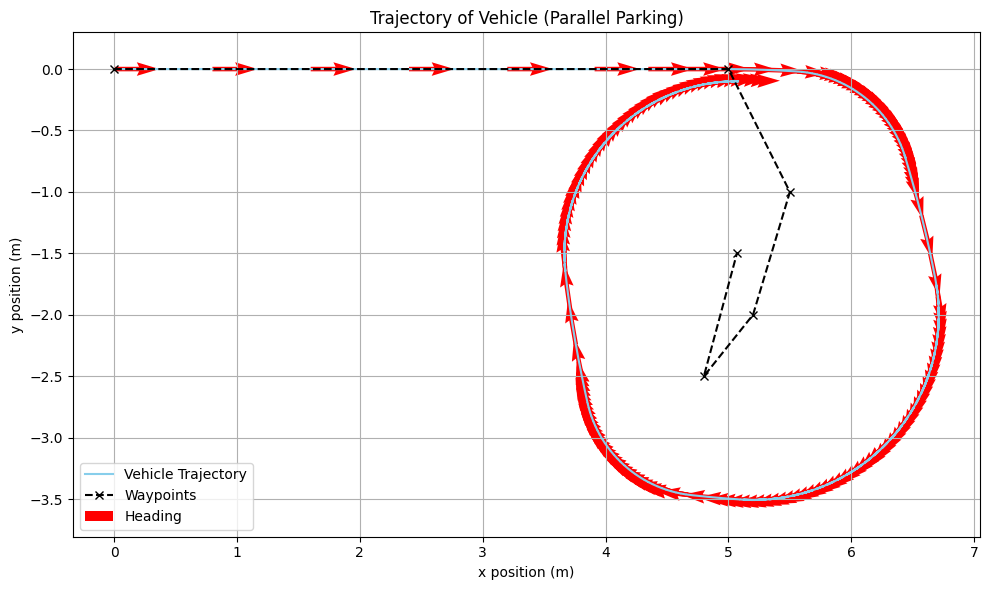

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(x_hist, y_hist, label="Vehicle Trajectory", color='skyblue')
plt.plot(waypoints[:, 0], waypoints[:, 1], 'kx--', label="Waypoints")
plt.quiver(x_hist[::10], y_hist[::10],
           np.cos(theta_hist[::10]), np.sin(theta_hist[::10]),
           scale=20, color='red', width=0.005, label="Heading")
plt.title("Trajectory of Vehicle (Parallel Parking)")
plt.xlabel("x position (m)")
plt.ylabel("y position (m)")
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()

# **Velocity Over Time**

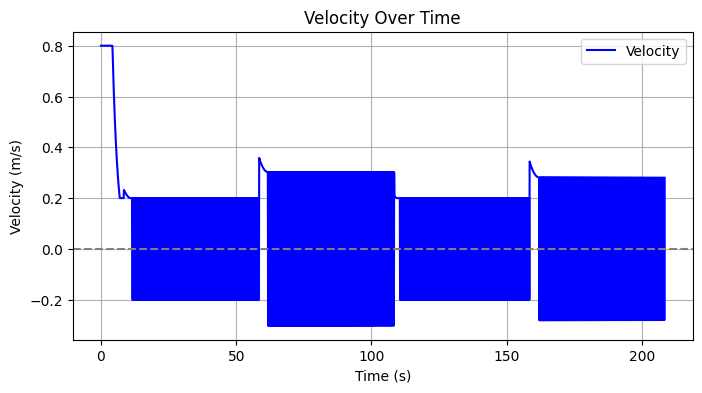

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(t_hist, v_hist, label="Velocity", color='blue')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Velocity Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.grid(True)
plt.legend()

# **Steering Angle Over Time**

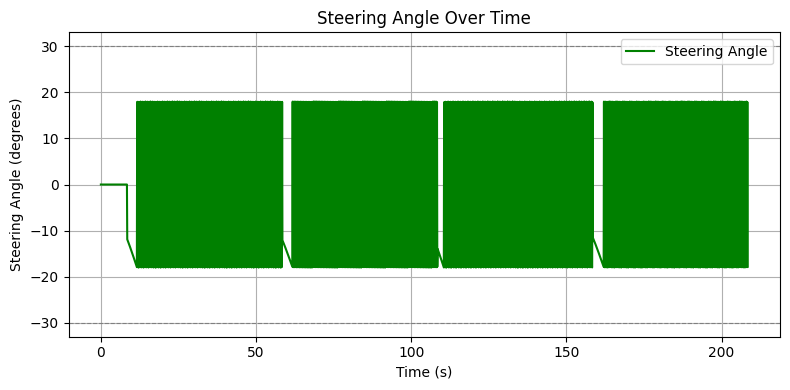

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(t_hist, phi_hist, label="Steering Angle", color='green')
plt.axhline(y=30, color='gray', linestyle='--', linewidth=0.8)
plt.axhline(y=-30, color='gray', linestyle='--', linewidth=0.8)
plt.title("Steering Angle Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Steering Angle (degrees)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
pip install ffmpeg  # or install via your OS package manager


In [ ]:
pip install matplotlib numpy


# **Parking Animation**

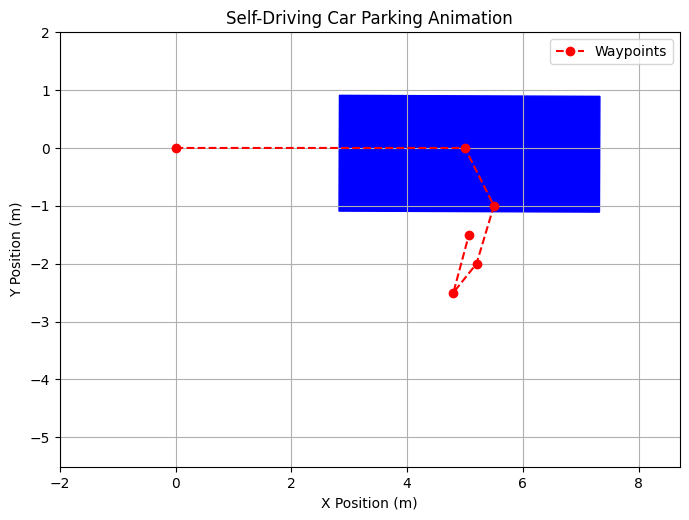

In [ ]:
import matplotlib.animation as animation

# Car dimensions (for drawing rectangle)
car_length = 4.5
car_width = 2.0

# Set up figure and axis
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(min(x_hist) - 2, max(x_hist) + 2)
ax.set_ylim(min(y_hist) - 2, max(y_hist) + 2)
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_title('Self-Driving Car Parking Animation')
ax.grid(True)
ax.plot(waypoints[:, 0], waypoints[:, 1], 'ro--', label='Waypoints')
ax.legend()
ax.set_aspect('equal')

# Car rectangle as a polygon (rotated)
car_patch = plt.Polygon([[0, 0]], closed=True, color='blue')
ax.add_patch(car_patch)

def get_car_corners(x, y, theta):
    """Return the four corners of the car given center (x, y) and heading theta."""
    L = car_length
    W = car_width
    cos_t, sin_t = np.cos(theta), np.sin(theta)

    # Car corners relative to center (assume rear axle at center for now)
    corners = np.array([
        [ L/2,  W/2],
        [ L/2, -W/2],
        [-L/2, -W/2],
        [-L/2,  W/2]
    ])

    # Rotation matrix
    R = np.array([[cos_t, -sin_t], [sin_t, cos_t]])
    rotated = corners @ R.T
    translated = rotated + np.array([x, y])
    return translated

def update(frame):
    x = x_hist[frame]
    y = y_hist[frame]
    theta = theta_hist[frame]
    corners = get_car_corners(x, y, theta)
    car_patch.set_xy(corners)
    return car_patch,

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(x_hist), interval=50, blit=True)

#from IPython.display import HTML
HTML(ani.to_jshtml())

# Save the animation as MP4 (requires ffmpeg)
ani.save("parking_animation.mp4", fps=20)
